### Import necessary Libraries

In [40]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from tqdm.auto import tqdm

### Prepare the Dataset

In [2]:
import torch.utils
import torch.utils.data


transform = torchvision.transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

train_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
    root='data/',
    train=True,
    transform=transform,
    target_transform=None,
    download=True
    ),
    batch_size=64,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
    root='data/',
    train=False,
    transform=transform,
    target_transform=None,
    download=True
    ),
    batch_size=64,
    shuffle=False
)

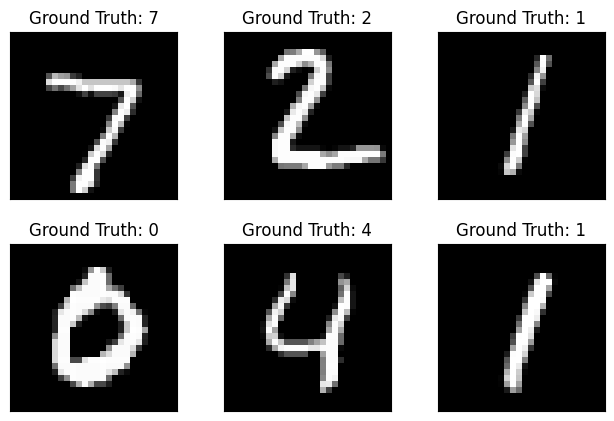

In [3]:
### Display some examples

batch_idx, (example_images, example_labels) = next(enumerate(test_loader))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_images[i][0], cmap='gray', interpolation=None)
    plt.title(f'Ground Truth: {example_labels[i]}')
    plt.xticks([])
    plt.yticks([])
plt.show()

### Model 0: Build a Baseline Model

In [4]:
class NetworkV0(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.sequential(x)

In [5]:
torch.manual_seed(42)

network_0 = NetworkV0(
    input_dim=784,
    hidden_dim=20,
    output_dim=10
)
network_0

NetworkV0(
  (sequential): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=network_0.parameters(), lr=0.1)

In [33]:
def accuracy_fn(y_logits, y):
    prediction = torch.argmax(torch.sigmoid(y_logits), dim=1)
    correct = torch.eq(prediction, y).sum()
    return correct * 100. / len(y)

def print_train_time(start, end):
    total_time = end-start
    print(f'Train time: {total_time:.3f} seconds.')
    return total_time

In [34]:
torch.manual_seed(42)
train_time_start = timer()

epochs = 3
for epoch in range(epochs):
    print(f'Epoch: {epoch}\n---------------')
    ### Training
    train_loss = 0
    train_acc = 0
    for batch_idx, (X, y) in enumerate(train_loader):
        network_0.train()
        y_pred = network_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    ### Testing
    network_0.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for X, y in test_loader:
            y_pred_test = network_0(X)
            test_loss += loss_fn(y_pred_test, y).item()
            test_acc += accuracy_fn(y_pred_test, y)
        test_loss /= len(test_loader)
        test_acc /= len(test_loader)
    print(f'Train loss: {train_loss:.5f} Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%')

train_end_time = timer()
total_train_time_network_0 = print_train_time(train_time_start, train_end_time)

Epoch: 0
---------------
Train loss: 0.37162 Train acc: 89.22% | Test loss: 0.31178 | Test acc: 90.76%
Epoch: 1
---------------
Train loss: 0.31400 Train acc: 91.08% | Test loss: 0.29152 | Test acc: 91.70%
Epoch: 2
---------------
Train loss: 0.30355 Train acc: 91.40% | Test loss: 0.29351 | Test acc: 91.59%
Train time: 7.944 seconds.


### Model 1: Incorporating non-linearity

In [35]:
class NetworkV1(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        return self.sequential(x)

In [36]:
torch.manual_seed(42)
network_1 = NetworkV1(
    input_dim=784,
    hidden_dim=20,
    output_dim=10
)
network_1

NetworkV1(
  (sequential): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=network_1.parameters(), lr=0.1)

In [39]:
def train_step(network, data_loader, loss_fn, optimizer, accuracy_fn):
    train_loss, train_acc = 0, 0
    network.train()
    for batch_idx, (X, y) in enumerate(data_loader):
        y_pred = network(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train loss: {train_loss:.5f} Train acc: {train_acc:.2f}%')

def test_step(network, data_loader, loss_fn, accuracy_fn):
    test_loss, test_acc = 0, 0
    network.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = network(X)
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y_pred, y)
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test loss: {test_loss:.5f} Test acc: {test_acc:.2f}%')

In [41]:
torch.manual_seed(42)
start_time = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n--------')
    train_step(network_1, train_loader, loss_fn, optimizer, accuracy_fn)
    test_step(network_1, test_loader, loss_fn, accuracy_fn)
end_time = timer()
total_train_time_network_1 = print_train_time(start_time, end_time)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Train loss: 0.40859 Train acc: 87.57%


 33%|███▎      | 1/3 [00:02<00:05,  2.68s/it]

Test loss: 0.22463 Test acc: 93.16%
Epoch: 1
--------
Train loss: 0.19460 Train acc: 94.28%


 67%|██████▋   | 2/3 [00:05<00:02,  2.62s/it]

Test loss: 0.16212 Test acc: 95.08%
Epoch: 2
--------
Train loss: 0.16331 Train acc: 95.18%


100%|██████████| 3/3 [00:07<00:00,  2.60s/it]

Test loss: 0.15538 Test acc: 95.57%
Train time: 7.871 seconds.


In [44]:
def eval_mode(network, data_loader, loss_fn, accuracy_fn):
    loss, acc = 0, 0
    network.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = network(X)
            loss += loss_fn(y_pred, y).item()
            acc += accuracy_fn(y_pred, y)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        'model_name': network.__class__.__name__,
        'model_loss': loss,
        'model_acc': acc.item()
    }

In [45]:
torch.manual_seed(42)

network_0_results = eval_mode(network_0, test_loader, loss_fn, accuracy_fn)
network_1_results = eval_mode(network_1, test_loader, loss_fn, accuracy_fn)

print(f'Network 0 Results:\n{network_0_results}')
print(f'Network 1 Results:\n{network_1_results}')

Network 0 Results:
{'model_name': 'NetworkV0', 'model_loss': 0.29351415489296057, 'model_acc': 91.59036254882812}
Network 1 Results:
{'model_name': 'NetworkV1', 'model_loss': 0.1553809048880817, 'model_acc': 95.57125854492188}
